In [2]:
from helper import *
from copy import deepcopy

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [3]:
# Iris Network
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Iris Dataset
iris = sklearn_datasets.load_iris()
X_iris = torch.FloatTensor(iris.data)
y_iris = torch.LongTensor(iris.target)

# Shuffle the dataset before splitting (deterministic with seed)
np.random.seed(42)
indices = np.random.permutation(len(X_iris))
X_iris_shuffled = X_iris[indices]
y_iris_shuffled = y_iris[indices]

# Split into train/test
split = int(0.67 * len(X_iris_shuffled))
X_iris_train, X_iris_test = X_iris_shuffled[:split], X_iris_shuffled[split:]
y_iris_train, y_iris_test = y_iris_shuffled[:split], y_iris_shuffled[split:]

iris_train_loader = DataLoader(TensorDataset(X_iris_train, y_iris_train), batch_size=16, shuffle=False)
iris_test_loader = DataLoader(TensorDataset(X_iris_test, y_iris_test), batch_size=16, shuffle=False)

In [36]:
iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.01)

iris_losses_base, trained_iris_base = train_model(iris_model, iris_train_loader, iris_criterion, iris_optimizer, num_epochs=30, seed=42, verbose=True)
print(f"{iris_losses_base[-5:]}")

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda
Epoch [20/30], Loss: 0.114425
[0.10459695969309125, 0.1108295087303434, 0.09987117217055388, 0.10124286663319383, 0.10741503190781389]


In [9]:
iris_inputs_base, iris_activations_base, iris_outputs_base = get_activations(trained_iris_base, iris_train_loader, dataset_type='iris')
single_iris_inputs, single_iris_activations, single_iris_outputs = get_activations(trained_iris_base, iris_test_loader, dataset_type='iris', indices=5)

In [10]:
indices_iris, distances_iris = find_knn(iris_activations_base, single_iris_activations, k=5, metric='l2')
filtered_iris_loader, filtered_size = create_filtered_dataloader(iris_train_loader, exclude_indices=indices_iris, batch_size=64, shuffle=False)

In [37]:
# Copy the trained model
iris_model_v2 = deepcopy(iris_model)
iris_optimizer_v2 = optim.Adam(iris_model_v2.parameters(), lr=0.01)
iris_optimizer_v2.load_state_dict(iris_optimizer.state_dict())
iris_losses_2, trained_iris_v2 = train_model(iris_model_v2, iris_train_loader, iris_criterion, iris_optimizer_v2, num_epochs=1, seed=42, verbose=True, continue_training=True)

# Print the loss to verify
print(iris_losses_2)

All seeds set to: 42
Training on device: cuda
[0.09634837534810815]


In [38]:
# Copy the trained model
iris_model_v3 = deepcopy(iris_model)
iris_optimizer_v3 = optim.Adam(iris_model_v3.parameters(), lr=0.01)
iris_optimizer_v3.load_state_dict(iris_optimizer.state_dict())
iris_losses_3, trained_iris_v3 = train_model(iris_model_v3, iris_train_loader, iris_criterion, iris_optimizer_v3, num_epochs=1, seed=42, verbose=True, continue_training=True)

# Print the loss to verify
print(iris_losses_3)

All seeds set to: 42
Training on device: cuda
[0.09532266083572592]


In [39]:
# Copy the trained model
iris_model_filter = deepcopy(iris_model)
iris_optimizer_filter = optim.Adam(iris_model_filter.parameters(), lr=0.01)
iris_optimizer_filter.load_state_dict(iris_optimizer.state_dict())
iris_losses_filter, trained_iris_filter = train_model(iris_model_filter, filtered_iris_loader, iris_criterion, iris_optimizer_filter, num_epochs=1, seed=42, verbose=True, continue_training=True)

# Print the loss to verify
print(iris_losses_filter)

All seeds set to: 42
Training on device: cuda
[0.08309126645326614]


In [40]:
predictions_iris_v2, probabilities_iris_v2, predicted_classes_iris_v2, sample_targets_iris_v2 = predict_and_show(trained_iris_v2, iris_test_loader, dataset_type='iris', indices=5)  # Single index
predictions_iris__filter, probabilities_iris__filter, predicted_classes_iris__filter, sample_targets_iris_filter = predict_and_show(trained_iris_filter, iris_test_loader, dataset_type='iris', indices=5)  # Single index

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      setosa       setosa       0.9999      
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      setosa       setosa       0.9999      


In [41]:
print(f"{nn.CrossEntropyLoss()(predictions_iris_v2, sample_targets_iris_v2):.8f}")
print(f"{nn.CrossEntropyLoss()(predictions_iris__filter, sample_targets_iris_filter):.8f}")

0.00011861
0.00012755


In [82]:
# Base Model prediction
predictions_base_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris, iris_test_loader, dataset_type='iris', indices=5)

# Filtered Model prediction
predictions_filter_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(filter_trained_iris, iris_test_loader, dataset_type='iris', indices=5)

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      setosa       setosa       1.0000      
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      setosa       setosa       0.9997      


In [83]:
print(nn.CrossEntropyLoss()(predictions_base_iris, sample_targets_iris))
print(nn.CrossEntropyLoss()(predictions_filter_iris, sample_targets_iris))

tensor(4.0411e-05)
tensor(0.0003)


In [84]:
# Function to calculate CrossEntropy loss for different k and indices
def calculate_cross_entropy_for_k_and_indices(model, train_loader, test_loader, list_of_k, list_of_indices):
    cross_results = {}
    for k in list_of_k:
        cross_results[k] = []
        for index in list_of_indices:
            # Get activations for the single sample
            single_inputs, single_activations, _ = get_activations(model, test_loader, dataset_type='iris', indices=index)
            
            # Find k-nearest neighbors
            indices_knn, _ = find_knn(iris_activations, single_activations, k=k, metric='cosine')
            
            # Create filtered dataloader
            filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=indices_knn, batch_size=64, shuffle=False)
            
            # Train a new model on the filtered dataset
            filtered_model = IrisNet()
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(filtered_model.parameters(), lr=0.01)
            _, trained_filtered_model = train_model(filtered_model, filtered_loader, criterion, optimizer, num_epochs=50, seed=42, verbose=False)
            
            # Predict and calculate CrossEntropy loss
            predictions, _, _, targets = predict_and_show(trained_filtered_model, test_loader, dataset_type='iris', indices=index)
            cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
            cross_results[k].append(cross_loss)
    return cross_results

In [89]:
list_of_k = list(range(1, 51, 3))
#list_of_k = [1, 5, 10, 50, 100, 250]

list_of_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

In [90]:
cross_results = calculate_cross_entropy_for_k_and_indices(trained_iris, iris_train_loader, iris_test_loader, list_of_k, list_of_indices)

All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      setosa       setosa       0.9991      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
1      setosa       setosa       0.9999      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      setosa       setosa       0.9991      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
10     versicolor   versicolor   0.9877      


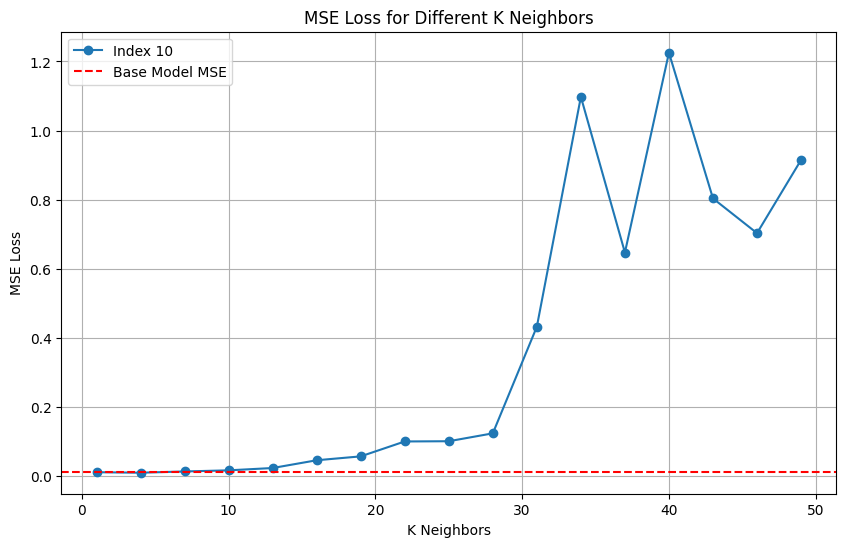

In [95]:
index_base = 10

predictions_base_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris, iris_test_loader, dataset_type='iris', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_iris, sample_targets_iris)

visualize_mse_results(cross_results, list_of_indices, selected_index=index_base, base_mse=base_error)  # Visualize for a specific index

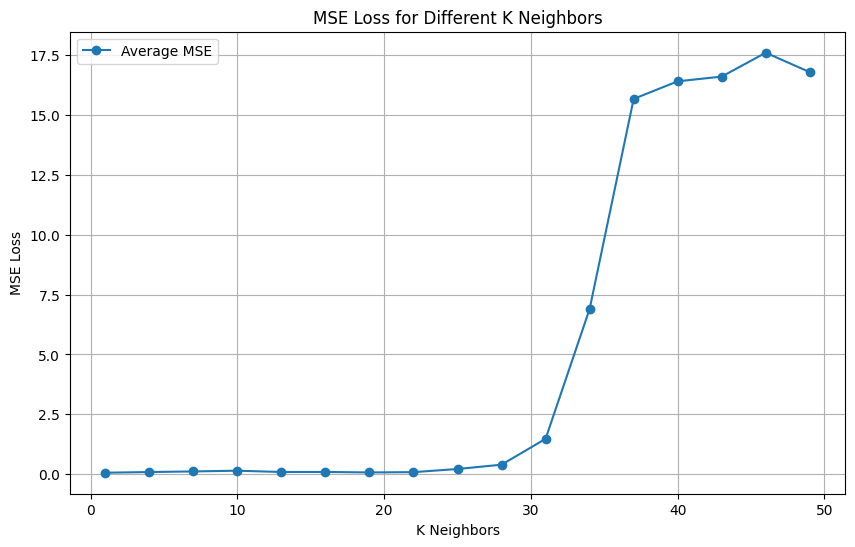

In [96]:
visualize_mse_results(cross_results, list_of_indices, average=True)  # Visualize averaged results

In [ ]:
# Function to calculate CrossEntropy loss for different k and indices with continue functionality
def calculate_cross_entropy_for_k_and_indices_with_continue(model, train_loader, test_loader, list_of_k, list_of_indices, base_epochs=50, extra_epochs=1):
    cross_results = {
        'closest_cross_entropy': {},
        'last_cross_entropy': {},
        'random_cross_entropy': {}
    }

    for k in list_of_k:
        cross_results['closest_cross_entropy'][k] = []
        cross_results['last_cross_entropy'][k] = []
        cross_results['random_cross_entropy'][k] = []

        for index in list_of_indices:

            # Get activations for the single sample
            single_inputs, single_activations, _ = get_activations(model, test_loader, dataset_type='iris', indices=index)

            # Find k-nearest neighbors for the entire dataset
            indices_knn, _ = find_knn(iris_activations, single_activations, k=len(iris_activations), metric='cosine')

            # Closest k neighbors
            closest_indices = indices_knn[:k]
            # Last in the list
            last_indices = indices_knn[-k:]
            # Random indices
            random_indices = np.random.choice(indices_knn, k, replace=False)

            for subset_name, subset_indices in zip(['closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'], [closest_indices, last_indices, random_indices]):

                # Create filtered dataloader
                filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=64, shuffle=False)

                # Train a new model to the base epochs
                filtered_model = IrisNet()
                optimizer_tmp = optim.Adam(filtered_model.parameters(), lr=0.01)
                criterion = nn.CrossEntropyLoss()
                train_model(filtered_model, train_loader, criterion, optimizer_tmp, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)

                # Train the model for one more epoch with the filtered dataset
                train_model(filtered_model, filtered_loader, criterion, optimizer_tmp, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)

                # Predict and calculate CrossEntropy loss
                predictions, _, _, targets = predict_and_show(filtered_model, test_loader, dataset_type='iris', indices=index)
                cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
                cross_results[subset_name][k].append(cross_loss)

    return cross_results